Attempting to use the approximation method presented in https://pubmed.ncbi.nlm.nih.gov/29454104/.

| **Parameter or variable** | **Role** |
|---------------------------|----------|
| $\mathcal{G}$            | Structural network of $N$ nodes |
| $\mathcal{V}$            | Set of nodes of $\mathcal{G}$ |
| $\mathcal{V}_i$          | $i$th node of $\mathcal{G}$ |
| $\mathcal{E}$            | Set of edges of $\mathcal{G}$ |
| $\mathbf{C}_s$           | Structural connectivity matrix |
| $C_{ij}$                 | Element $(i,j)$ of $\mathbf{C}_s$ |
| $\mathbf{C}_f$           | Functional connectivity matrix |
| $\mathbf{C}_f^{GD}$      | Graph diffusion estimate of $\mathbf{C}_f$ |
| $\mathbf{C}_f^{eig}$     | Eigen decomposition estimate of $\mathbf{C}_f$ |
| $\delta_i$               | Weighted degree of node $i$ |
| $\mathcal{L}$            | Laplacian of $\mathbf{C}_s$ |
| $\mathbf{U}_l$           | Eigenvectors of $\mathcal{L}$ |
| $\Lambda_l$              | Eigenvalues of $\mathcal{L}$ |
| $\Lambda_f^{eig}$        | Proposed model eigenvalues |
| $\Lambda_f^{GD}$         | Eigenvalues of the GD model |
| $\mathbf{u}_i$           | $i$th eigenvector of $\mathcal{L}$ |
| $\Delta$                 | Diagonal degree matrix of $\mathbf{C}_s$ |
| $\beta$                  | Diffusion rate |


$\mathbf{C}_f^{eig} = \sum_{i \in M} u_i u_i^{\prime} \left(a e^{-\alpha \lambda_i} + b\right)$

$M$ is a subset of indices of eigenvectors to use for the approximation.

In [187]:
import numpy as np
from scipy.sparse.linalg import eigsh

In [188]:
def compute_C_f(M, U, L, a, alpha, b):
    '''
    M: subset of indices
    U: eigenvector matrix
    L: eigenvalue matrix
    '''

    n, m = U.shape
    Cf_eig = np.zeros((n, n))
    
    M = min(M, m)
    
    for i in range(M):
        u_i = U[:, i].reshape(-1, 1) 
        term = a * np.exp(-alpha * L[i]) + b 
        Cf_eig += term * (u_i @ u_i.T)
        
    return Cf_eig

In [189]:
def get_spectrum(C):
    evals, evecs = np.linalg.eig(C)

    sorted_indices = np.argsort(evals)
    sorted_eigenvalues = evals[sorted_indices]
    sorted_eigenvectors = evecs[:, sorted_indices]
    
    return sorted_eigenvalues, sorted_eigenvectors

In [190]:
def get_laplacian(C):
    D = np.diag(np.sum(C, axis=1))
    laplacian = D - C

    return laplacian

In [191]:
from Connectome import *

In [192]:
connectome = Connectome(file='/Users/shamanthk/Documents/Research/IS-modeling-connectomes/Averaged_1015.graphml', label='Average')
C_s = connectome.read_matrix()
net = connectome.read_net(use_3d=True)
C_s = nx.to_numpy_array(net, weight='FA_mean')

In [193]:
L_s = get_laplacian(C_s)

L_s_evals, L_s_evecs = get_spectrum(L_s)

In [194]:
a = 1.0
b = 0.5
alpha = 0.1
M = 6

C_f = compute_C_f(M, L_s_evecs, L_s_evals, a, alpha, b)

C_f_evals, C_f_evecs = get_spectrum(C_f)
C_f_evals, C_f_evecs = np.real(C_f_evals), np.real(C_f_evecs)
C_s_evals, C_s_evecs = get_spectrum(C_s)
C_s_evals, C_s_evecs = np.real(C_s_evals), np.real(C_s_evecs)

In [203]:
C_f_evecs[:,0]

array([-0.44951894,  0.04327617,  0.00319864, ...,  0.02043194,
        0.00191866, -0.01079687])

In [204]:
C_f_evals

array([0.00000000e+00, 4.96467490e-17, 6.02289715e-17, ...,
       9.99879801e-01, 9.99967386e-01, 1.00000000e+00])

In [205]:
L_s_evals

array([0.00000000e+00, 1.03721169e-05, 3.82294600e-05, ...,
       9.55087267e-01, 9.75026733e-01, 1.00000000e+00])

In [196]:
L_s_evecs[0]

array([ 3.13882410e-02,  1.02411564e-03,  1.02755743e-03, ...,
       -5.41094148e-06,  4.17532946e-05,  6.69044101e-06])

In [197]:
L_s_evals.shape

(1015,)

In [198]:
C_s_evecs.shape

(1015, 1015)

Should they not be the same?

In [199]:
L_s_evals = (L_s_evals - min(L_s_evals)) / (max(L_s_evals) - min(L_s_evals))
C_f_evals = (C_f_evals - min(C_f_evals)) / (max(C_f_evals) - min(C_f_evals))

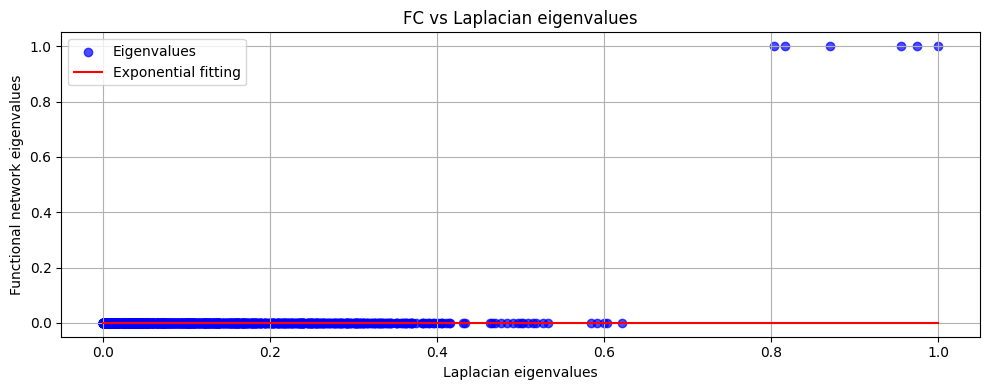

In [200]:
from scipy.optimize import curve_fit

def exponential_fit(x, a, b):
    return a * np.exp(-b * x)

params, _ = curve_fit(exponential_fit, L_s_evals, C_f_evals)
a, b = params

plt.figure(figsize=(10, 4))
plt.scatter(L_s_evals, C_f_evals, color='b', label='Eigenvalues', alpha=0.7)
plt.plot(L_s_evals, exponential_fit(L_s_evals, a, b), color='r', label='Exponential fitting')
plt.title("FC vs Laplacian eigenvalues")
plt.xlabel("Laplacian eigenvalues")
plt.ylabel("Functional network eigenvalues")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [201]:
C_f

array([[0.00148543, 0.0014857 , 0.00148528, ..., 0.00148566, 0.00148569,
        0.0014855 ],
       [0.0014857 , 0.00148664, 0.00148608, ..., 0.00148678, 0.00148682,
        0.00148658],
       [0.00148528, 0.00148608, 0.00148557, ..., 0.00148619, 0.00148622,
        0.00148601],
       ...,
       [0.00148566, 0.00148678, 0.00148619, ..., 0.00148697, 0.00148701,
        0.00148677],
       [0.00148569, 0.00148682, 0.00148622, ..., 0.00148701, 0.00148706,
        0.00148681],
       [0.0014855 , 0.00148658, 0.00148601, ..., 0.00148677, 0.00148681,
        0.00148657]])

In [202]:
C_s

array([[0.        , 0.00092777, 0.00185118, ..., 0.        , 0.        ,
        0.        ],
       [0.00092777, 0.        , 0.00222333, ..., 0.        , 0.        ,
        0.        ],
       [0.00185118, 0.00222333, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.15078947,
        0.26700513],
       [0.        , 0.        , 0.        , ..., 0.15078947, 0.        ,
        0.11737212],
       [0.        , 0.        , 0.        , ..., 0.26700513, 0.11737212,
        0.        ]])